In [1]:
# !pip uninstall torch torchaudio torchvision -y

In [2]:
# !pip install torch==2.2.2 torchaudio==2.2.2

In [3]:
!pip install torch torchaudio torchvision datasets -q

In [171]:
import random
import IPython
import warnings
warnings.filterwarnings("ignore")

import datasets

from datasets.utils import DownloadManager

import numpy as np
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, roc_curve, auc

import torch
import torchaudio
import torchaudio.transforms as T

from torch.utils.data import DataLoader, Dataset

import os
import sys

from tqdm import tqdm
import torchvision
import soundfile as sf
import torch.nn as nn
import torchvision.models as models
from librosa import util
import librosa.feature

import matplotlib.pyplot as plt
import math

In [8]:
sys.path.append('src')

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Dataset .zip from link

Logical access (LA):

- ```speaker_id:``` LA_****, a 4-digit speaker ID
- ```audio_file_name:``` name of the audio file
- ```audio:``` '****.flac'  the path to the downloaded audio file in FLAC format (https://xiph.org/flac/).
- ```system_id:``` ID of the speech spoofing system (A01 - A19), or, for bonafide speech SYSTEM-ID is left blank ('-')
- ```key:``` 'bonafide' for genuine speech, or, 'spoof' for spoofing speech

## ASVspoof2019

In [7]:
# # For kaggle
# import sys
# sys.path.append('/kaggle/input/modulesspeechdetection')


In [10]:
%%time
from load_avsspoof19 import ASVspoof2019

dl_manager = DownloadManager()

speech_dataset = ASVspoof2019()
asv_datasets = speech_dataset._split_generators(dl_manager)

Computing checksums: 100%|##########| 1/1 [00:23<00:00, 23.55s/it]

CPU times: user 22.5 s, sys: 1.25 s, total: 23.7 s
Wall time: 1min


In [11]:
# 0 - train, 1 - eval, 2 - test in asv_datasets
train_metadata_filepath = asv_datasets[0].gen_kwargs["metadata_filepath"]
train_audios_dir = asv_datasets[0].gen_kwargs["audios_dir"]

val_metadata_filepath = asv_datasets[1].gen_kwargs["metadata_filepath"]
val_audios_dir = asv_datasets[1].gen_kwargs["audios_dir"]

test_metadata_filepath = asv_datasets[2].gen_kwargs["metadata_filepath"]
test_audios_dir = asv_datasets[2].gen_kwargs["audios_dir"]

In [12]:
train_samples = speech_dataset._generate_examples(train_metadata_filepath, train_audios_dir)
val_samples = speech_dataset._generate_examples(val_metadata_filepath, val_audios_dir)
test_samples = speech_dataset._generate_examples(test_metadata_filepath, test_audios_dir)

## ASVspoof2021

In [172]:
%%time
from load_avsspoof21 import ASVspoof2021

dl_manager = DownloadManager(data_dir="data")

speech_dataset = ASVspoof2021()
asv_datasets = speech_dataset._split_generators(dl_manager)

Computing checksums:  20%|##        | 1/5 [00:27<01:48, 27.05s/it]

CPU times: user 1min 50s, sys: 30.7 s, total: 2min 21s
Wall time: 3min 24s


In [173]:
test_samples_21 = speech_dataset._generate_examples(
    asv_datasets[0].gen_kwargs["metadata_filepath"],
    asv_datasets[0].gen_kwargs["audios_dir"]
)

## Listen to random sample

Display some audio from train/validation set.

In [11]:
def get_sample(samples):
    return random.sample(samples, k=1)[0]

sample = get_sample(train_samples)
sample

{'speaker_id': 'LA_0093',
 'audio_file_name': 'LA_T_4167933',
 'system_id': 'A06',
 'key': 'spoof',
 'audio': '/root/.cache/huggingface/datasets/downloads/extracted/911103f86670b6f7e96211444d0f39fc5ffab511156a395f67b098c2f45dce18/LA/ASVspoof2019_LA_train/flac/LA_T_4167933.flac'}

In [12]:
print(sample['key'])
IPython.display.Audio(sample['audio'])

spoof


In [13]:
sample = get_sample(val_samples)
sample

{'speaker_id': 'LA_0078',
 'audio_file_name': 'LA_D_7064559',
 'system_id': 'A02',
 'key': 'spoof',
 'audio': '/root/.cache/huggingface/datasets/downloads/extracted/911103f86670b6f7e96211444d0f39fc5ffab511156a395f67b098c2f45dce18/LA/ASVspoof2019_LA_dev/flac/LA_D_7064559.flac'}

In [14]:
print(sample['key'])
IPython.display.Audio(sample['audio'])

spoof


## Audio preprocessing


In [13]:
def audio_preprocess(waveform, sample_rate, resample_rate, desired_duration):
    """
        Resample audio to target frequency (16 kHz or 22.05 kHz) \
        Set equal duration for all audios
    """
    resampler = T.Resample(sample_rate, resample_rate)
    resampled_waveform = resampler(waveform)

    desired_length = int(desired_duration * resample_rate)
    if len(resampled_waveform) < desired_length:
        resampled_waveform = resampled_waveform.tile(((desired_length // resampled_waveform.shape[1]) + 1,))
    resampled_waveform = resampled_waveform[:,0: desired_length]

    return resampled_waveform


def peak_normalize(waveform):
    """
        Normalize audio
    """
    waveform /= torch.max(torch.abs(waveform))
    return waveform

In [14]:
class AudioDataset(Dataset):
    def __init__(self, raw_dataset, desired_duration, resample_rate, transform=None):
        self.raw_data = raw_dataset
        self.transform = transform
        self.sample_rate = resample_rate
        self.duration = desired_duration

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.raw_data[idx]['audio'])
        if self.transform:
            waveform = self.transform[0](waveform, sample_rate, self.sample_rate, self.duration)
            waveform = self.transform[1](waveform)

        label = 1 if self.raw_data[idx]['key'] == 'spoof' else 0
        return waveform, label

## ASVspoof19

In [199]:
_DURATION = 6
_SAMPLE_RATE = 16_000
_BATCH_SIZE = 36
_TEST_SIZE = math.floor(len(test_samples) / _BATCH_SIZE) * _BATCH_SIZE

train_dataset = AudioDataset(train_samples, _DURATION, _SAMPLE_RATE, transform=[audio_preprocess, peak_normalize])
train_loader= DataLoader(train_dataset, batch_size=_BATCH_SIZE, shuffle=True)

test_dataset = AudioDataset(
    test_samples[:_TEST_SIZE],
    _DURATION, _SAMPLE_RATE,
    transform=[audio_preprocess, peak_normalize]
)
test_loader= DataLoader(test_dataset, batch_size=_BATCH_SIZE, shuffle=False)

In [204]:
len(train_samples), len(train_loader)

(25380, 705)

## ASVspoof21

In [200]:
_DURATION = 6
_SAMPLE_RATE = 16_000
_BATCH_SIZE = 36

test_dataset_21 = AudioDataset(
    test_samples_21[:_TEST_SIZE],
    _DURATION, _SAMPLE_RATE,
    transform=[audio_preprocess, peak_normalize]
)
test_loader_21 = DataLoader(test_dataset_21, batch_size=_BATCH_SIZE, shuffle=False)

In [205]:
len(test_samples_21), len(test_loader_21)

(611829, 1978)

# Feature Extraction Definition
Log power spectrum (LPS), Mel-frequency cepstrum coefficient (MFCC), constant Q cepstral coefficient (CQCC).

In [17]:
from feature_ext import get_MFCC, get_CQCC, get_LPS

feature_extractor = 'MFCC'

In [21]:
sample = next(iter(train_loader))[0]
get_CQCC(sample, train_loader.dataset.sample_rate).shape

torch.Size([36, 12, 188])

# Model definition

In [22]:
# model = torchvision.models.resnet18(pretrained=True)
# n_ftrs = model.fc.in_features
# model.fc=nn.Linear(n_ftrs,2)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)

In [18]:
from models import TE_ResNet

In [37]:
model = TE_ResNet(
    n_features=20,
    n_frames=188,
    num_layers=6,
    heads=8,
    hidden_size=256,
    output_channels=128,
    batch_size=_BATCH_SIZE,
    device=device,
).to(device)

In [110]:
model = torchvision.models.resnet18(pretrained=True)
# TODO your code
n_ftrs = model.fc.in_features
model.fc=nn.Linear(n_ftrs,2)
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)
model.softmax = nn.Softmax(dim=1)
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(9, 3), stride=(3, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
model

TE_ResNet(
  (transformer_encoder): TransformerEncoder(
    (linear): Linear(in_features=20, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (feed_forward): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (encoder_layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (nor

# Metrics Definition

In [ ]:
from metrics import compute_det_curve, compute_eer, plot_roc

# Training

In [158]:
def truncate_sequence(features, max_length):
    batch_size, seq_length, feature_dim = features.size()
    if seq_length > max_length:
        features = features[:, :max_length, :]
    else:
        padding = torch.zeros(batch_size, max_length - seq_length, feature_dim, device=features.device)
        features = torch.cat((features, padding), dim=1)
    return features

def train_loop(model, loader, feature_extractor, criterion, optimizer, n_epochs, device, max_length):
    feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
    }

    for epoch in range(n_epochs):
        model.train(True)
        sum_loss = 0.0
        num_correct = 0
        total_samples = 0
        acc, precision, recall = 0.0, 0.0, 0.0

        for data, labels in tqdm(loader):
            data = data.to(device)
            labels = labels.to(device)

            # Extract features
            if feature_extractor in feature_extr:
                features = feature_extr[feature_extractor](data, loader.dataset.sample_rate)
            else:
                raise ValueError(f"Invalid feature extractor: {feature_extractor}")

            features = features.to(device)

            # Forward pass through the model
            features = features.unsqueeze(1)
            output = model(features)

            # Check for shape mismatch
            if output.shape[0] != labels.shape[0]:
                raise ValueError(f"Mismatch in batch sizes: output batch size {output.shape[0]}, labels batch size {labels.shape[0]}")

            # Compute loss
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            sum_loss += loss.item()
            max_val, predicted = output.max(1)
            # num_correct += (predicted == labels).sum().item()
            acc += balanced_accuracy_score(labels.cpu(), predicted.cpu())
            # total_samples += data.size(0)
            precision += precision_score(labels.cpu(), predicted.cpu(),  average='binary')
            recall += recall_score(labels.cpu(), predicted.cpu(),  average='binary')

        # train_accuracy = num_correct / total_samples
        train_avg_acc = acc / len(loader)
        train_avg_loss = sum_loss / len(loader)
        train_avg_prec = precision / len(loader)
        train_avg_recall = recall / len(loader)
        print(f'Epoch [{epoch+1}/{n_epochs}], Training Accuracy: {train_avg_acc:.4f}, Training Loss: {train_avg_loss:.4f}, \
Training Precision: {train_avg_prec:.4f}, Training Recall: {train_avg_recall:.4f}')



In [112]:
num_epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [113]:
torch.cuda.empty_cache()
train_loop(
    model,
    train_loader,
    feature_extractor=feature_extractor,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=num_epochs,
    device=device,
    max_length=188
)

  7%|█████████▉                                                                                                                                | 51/705 [00:28<06:09,  1.77it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
  8%|██████████▌                                                                                                                               | 54/705 [00:29<06:05,  1.78it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
  8%|███████████▎                                                                                                                              | 58/705 [00:32<05:51,  1.84it/s]/usr/local/lib/py

Epoch [1/3], Training Accuracy: 0.9341, Training Loss: 0.0735,         Training Precision: 0.9843, Training Recall: 0.9869


  2%|██▋                                                                                                                                       | 14/705 [00:07<06:08,  1.88it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
 10%|█████████████▎                                                                                                                            | 68/705 [00:36<05:40,  1.87it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
 10%|█████████████▉                                                                                                 

Epoch [2/3], Training Accuracy: 0.9784, Training Loss: 0.0301,         Training Precision: 0.9944, Training Recall: 0.9952


  7%|█████████▉                                                                                                                                | 51/705 [00:28<06:21,  1.71it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 15%|████████████████████▊                                                                                                                    | 107/705 [00:59<05:25,  1.84it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
 32%|███████████████████████████████████████████▌                                                                                             | 224/705 [02:04<04:27,  1.80it/s]/usr/local/lib/py

Epoch [3/3], Training Accuracy: 0.9840, Training Loss: 0.0236,         Training Precision: 0.9960, Training Recall: 0.9959


In [115]:
torch.save(model.state_dict(), f"weights_resnet18.pt")

# Evaluation on ASVspoof2019

In [169]:
def evaluate_model(model, test_loader, feature_extractor, criterion, device, max_length):
    feature_extr = {
        'MFCC': get_MFCC,
        'CQCC': get_CQCC,
        'LPS': get_LPS
    }

    model.eval()
    test_loss = 0.0
    test_correct = 0
    total_test_samples = 0
    target_scores, non_target_scores = [], []
    acc, precision, recall = 0.0, 0.0, 0.0
    true_labels = []
    

    with torch.no_grad():
        for waveform, label in tqdm(test_loader):
            waveform, label = waveform.to(device), label.to(device)

            # Extract features
            if feature_extractor in feature_extr:
                features = feature_extr[feature_extractor](waveform, test_loader.dataset.sample_rate)
            else:
                raise ValueError(f"Invalid feature extractor: {feature_extractor}")


            features = features.to(device)

            # Forward pass through the model
            features = features.unsqueeze(1)
            output = model(features)

            # Check for shape mismatch
            if output.shape[0] != label.shape[0]:
                raise ValueError(f"Mismatch in batch sizes: output batch size {output.shape[0]}, label batch size {label.shape[0]}")

            # Compute loss
            loss = criterion(output, label)
            test_loss += loss.item()
    
            _, predicted = output.max(1)
            acc += balanced_accuracy_score(label.cpu(), predicted.cpu())
            # test_correct += (predicted == label).sum().item()
            # total_test_samples += label.size(0)
            target_scores.append(output[:,1].cpu())
            non_target_scores.append(output[:,0].cpu())
            precision += precision_score(label.cpu(), predicted.cpu(),  average='binary')
            recall += recall_score(label.cpu(), predicted.cpu(),  average='binary')
            true_labels.append(label.cpu())
            
    true_labels = torch.cat(true_labels, dim = 0)
    target_scores = torch.cat(target_scores, dim = 0)

    plot_roc(true_labels, target_scores)
    

    # test_accuracy = test_correct / total_test_samples
    test_avg_acc = acc / len(test_loader)
    test_loss /= len(test_loader)
    test_avg_prec = precision / len(test_loader)
    test_avg_recall = recall / len(test_loader)

    print(f'Val Loss: {test_loss:.4f}, Val Accuracy: {test_avg_acc:.4f}, \
Val Precision: {test_avg_prec:.4f}, Val Recall: {test_avg_recall:.4f}')#, Val EER: {eer}')
    # eer, threshold = compute_eer(np.array(target_scores), np.array(non_target_scores))

    return test_loss, test_avg_acc, target_scores, non_target_scores


  4%|██████                                                                                                                                   | 88/1978 [00:46<17:11,  1.83it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 13%|█████████████████                                                                                                                       | 248/1978 [02:11<14:39,  1.97it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 15%|████████████████████▏                                                                                                                   | 294/1978 [02:36<14:39,  1.92it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2458: UserWarning: 

ROC_AUC = 0.936


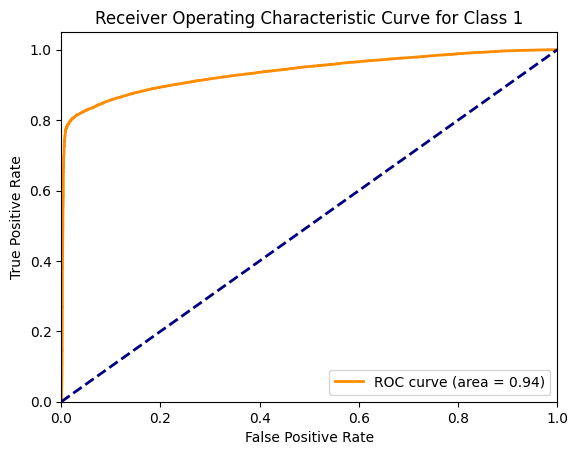

Val Loss: 0.7327, Val Accuracy: 0.8894, Val Precision: 0.9953, Val Recall: 0.8149


In [170]:
torch.cuda.empty_cache()
target_scores, non_target_scores = [], []
loss, acc, target_scores, non_target_scores = evaluate_model(
    model,
    test_loader,
    feature_extractor=feature_extractor,
    criterion=criterion,
    device=device,
    max_length=188
)

# Evaluation on ASVspoof2021

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1978/1978 [18:03<00:00,  1.83it/s]


ROC_AUC = 0.819


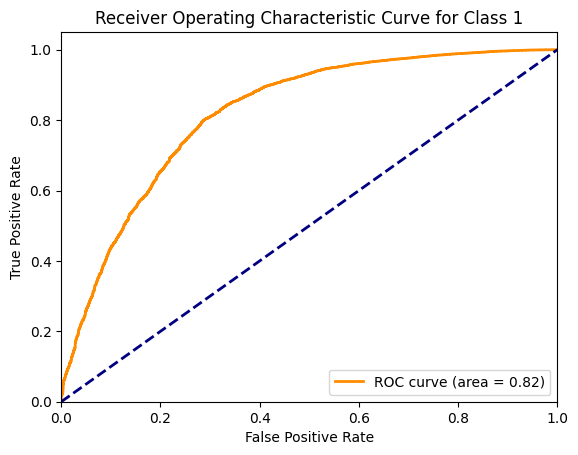

Val Loss: 0.5500, Val Accuracy: 0.7778, Val Precision: 0.9851, Val Recall: 0.8421


In [203]:
torch.cuda.empty_cache()
target_scores, non_target_scores = [], []
loss, acc, target_scores, non_target_scores = evaluate_model(
    model,
    test_loader_21,
    feature_extractor=feature_extractor,
    criterion=criterion,
    device=device,
    max_length=188
)